In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import regionmask 

In [9]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

In [10]:
# loading other layers
outline           = gpd.read_file(f"{gis_folder}\\hudson_basin_26918.gpkg",driver="GPKG",crs="EPSG:26918") 
outline_buffered  = gpd.read_file(f"{gis_folder}\\hudson_basin_buffered.gpkg",crs="EPSG:26918")

# fixing crs
for layer in [outline,outline_buffered]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

Daily Gleam data from https://www.gleam.eu/#datasets, too large to add to repo so locally extracted

In [12]:
path = "C:\\Users\\david\\Documents\\EP_data_ENVM1502\\"

In [69]:
lst_dfs_gleam = []
for year in np.linspace(1980,2020,2020-1980+1,dtype=int):
    data_set_path = f'{path}\\EP_{year}_GLEAM_v3.7a.nc'
    ds_gleam = xr.load_dataset(data_set_path)
    mask = regionmask.mask_geopandas(outline_buffered, 
                                     ds_gleam['Ep'].lon.to_numpy(), 
                                     ds_gleam['Ep'].lat.to_numpy(),
                                     lon_name="lon",
                                     lat_name="lat")
    cropped_ds_gleam = ds_gleam.where(mask==0)
    mean_gleam = cropped_ds_gleam.mean(dim=["lat","lon"])
    df_gleam = pd.DataFrame(mean_gleam.Ep.to_pandas(),columns=["Pe"])
    lst_dfs_gleam.append(df_gleam)

In [73]:
gleam_df_complete = pd.concat(lst_dfs_gleam)

In [79]:
files = glob.glob(f"{data_folder}\\combined*.parquet")
df_all_data = pd.read_parquet(files[0])
Ep = df_all_data["Pev"].loc["1980":]

<AxesSubplot: xlabel='time'>

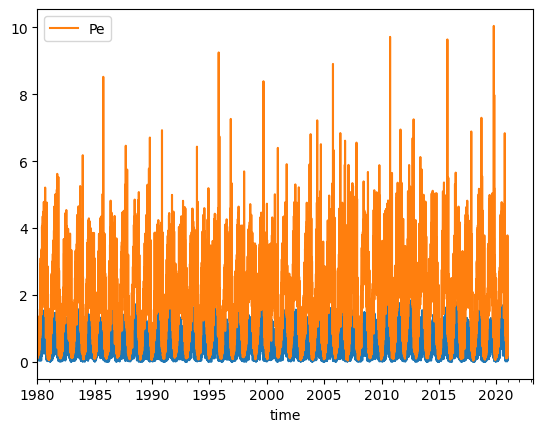

In [80]:
fig, ax = plt.subplots()
Ep.plot(ax=ax)
gleam_df_complete.plot(ax=ax)

In [81]:
gleam_df_complete.to_parquet(f'{data_folder}\\EP\\combined_PE_GLEAM.parquet')